In [747]:
import numpy as np
from math import sin, cos, pi
import matplotlib.pyplot as plt
from scipy.stats import qmc
import yfinance as yf
%matplotlib widget

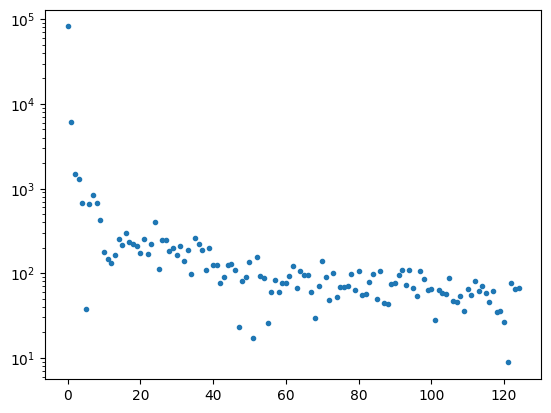

In [536]:
qqq = yf.Ticker("QQQ")
qqq_data = qqq.history(period='1y')
prices = np.array(qqq_data["Close"])

nyquist_freq = len(prices) // 2
spectrum = np.fft.fft(prices)[:nyquist_freq]

plt.plot(np.abs(spectrum), '.')
plt.yscale('log')


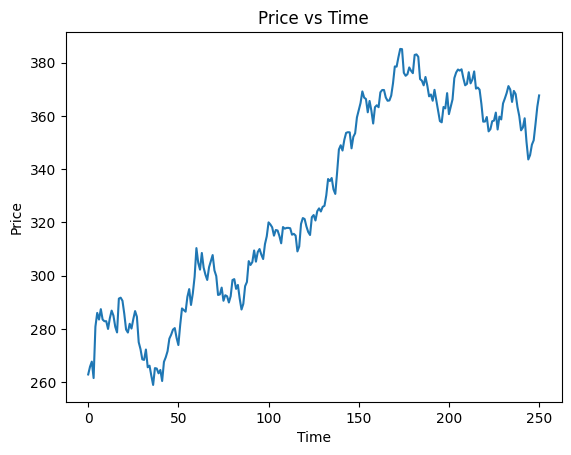

In [537]:
plt.plot(prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price vs Time')
plt.show()


262.89801025390625
30.964935191972824


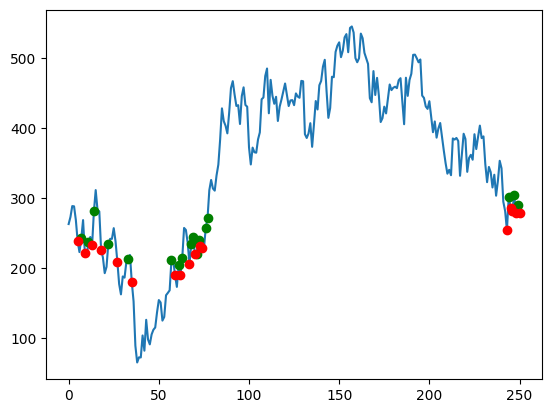

In [728]:
T = len(prices) #number of time steps
n = nyquist_freq #number of fourier terms
# As = 1 / np.arange(1,n+1) #amplitudes of fourier terms
As = np.abs(spectrum) #amplitudes of fourier terms
start_price = prices[0]

thresS = 1
thresB = -1
sell_max = 20
buy_max= 20

thetas = np.random.uniform(0, 2*pi, size=n) #phases of fourier terms

offset = -2*pi/T*sum(As*np.sin(thetas)) + start_price

last_trans = start_price
invest = 0 #shares
cash = 10 

sell_log = []
buy_log = []

P = np.zeros(T)
for k in range(T):
    t = 2*pi*k/T
    for i in range(n):
        P[k] += As[i]*sin(i*t + thetas[i])
    P[k] *= 2*pi/T
    P[k] += offset

    if(P[k] > last_trans + thresS and invest > 0):
        sell_amt = min(sell_max, invest*P[k])
        invest -= sell_amt/P[k]
        cash += sell_amt
        sell_log.append(k)
        # print(f"sell {sell_amt/P[k]} shares at {P[k]} for ${sell_amt}, cash={round(cash,2)}, invest={round(invest,2)}")
        last_trans = P[k]
    if(P[k] < last_trans + thresB and cash > 0):
        buy_amt = min(buy_max, cash)
        invest += buy_amt/P[k]
        cash -= buy_amt
        buy_log.append(k)
        # print(f"buy {buy_amt/P[k]} shares at {P[k]} for -${buy_amt}, cash={round(cash,2)}, invest={round(invest,2)}")
        last_trans = P[k]

plt.plot(P)
for k in sell_log:
    plt.plot(k, P[k], 'go')
for k in buy_log:
    plt.plot(k, P[k], 'ro')

print(P[0])
print(cash + invest*P[-1])

Average of money-log: 21.93448925846798


Text(0, 0.5, 'Frequency')

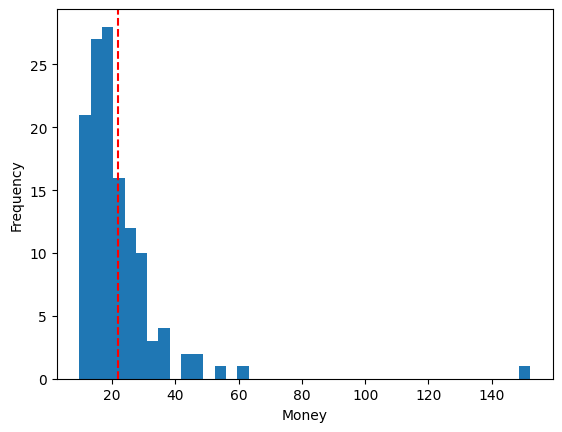

In [735]:
T = len(prices) #number of time steps
n = nyquist_freq #number of fourier terms
# As = 1 / np.arange(1,n+1) #amplitudes of fourier terms
As = np.abs(spectrum) #amplitudes of fourier terms
start_price = prices[0]

thresS = 1
thresB = -1
sell_max = 20
buy_max= 20

trials = 2**7
lhc = qmc.Sobol(d=n)
thetass = lhc.random(trials) * 2*pi

money_log = []
for trial in range(trials):
    # thetas = np.random.uniform(0, 2*pi, size=n) #phases of fourier terms
    thetas = thetass[trial]

    offset = -2*pi/T*sum(As*np.sin(thetas)) + start_price

    last_trans = start_price
    invest = 0 #shares
    cash = 10


    P = np.zeros(T)
    for k in range(T):
        t = 2*pi*k/T
        for i in range(n):
            P[k] += As[i]*sin(i*t + thetas[i])
        P[k] *= 2*pi/T
        P[k] += offset

        if(P[k] > last_trans + thresS and invest > 0):
            sell_amt = min(sell_max, invest*P[k])
            invest -= sell_amt/P[k]
            cash += sell_amt
            last_trans = P[k]
        if(P[k] < last_trans + thresB and cash > 0):
            buy_amt = min(buy_max, cash)
            invest += buy_amt/P[k]
            cash -= buy_amt
            last_trans = P[k]

    money_log.append(cash + invest*P[-1])

average_money_log = sum(money_log) / len(money_log)
print(f"Average of money-log: {average_money_log}")

plt.hist(money_log, bins=40)
plt.axvline(x=average_money_log, color='r', linestyle='--')

plt.xlabel('Money')
plt.ylabel('Frequency')

buy 7.65 shares at 261.55 for -$2000, cash=8000, invest=7.65
sel 7.12 shares at 280.85 for +$2000, cash=10000, invest=0.53
sel 0.53 shares at 286.02 for +$150.3, cash=10150.3, invest=0.0
buy 7.05 shares at 283.52 for -$2000, cash=8150.3, invest=7.05
sel 6.96 shares at 287.44 for +$2000, cash=10150.3, invest=0.1
buy 7.05 shares at 283.52 for -$2000, cash=8150.3, invest=7.15
buy 7.14 shares at 279.99 for -$2000, cash=6150.3, invest=14.29
sel 7.04 shares at 284.02 for +$2000, cash=8150.3, invest=7.25
sel 6.97 shares at 286.88 for +$2000, cash=10150.3, invest=0.28
buy 7.02 shares at 284.99 for -$2000, cash=8150.3, invest=7.3
buy 7.12 shares at 280.81 for -$2000, cash=6150.3, invest=14.42
buy 7.18 shares at 278.68 for -$2000, cash=4150.3, invest=21.6
sel 6.86 shares at 291.38 for +$2000, cash=6150.3, invest=14.73
buy 7.0 shares at 285.7 for -$2000, cash=4150.3, invest=21.73
buy 7.15 shares at 279.78 for -$2000, cash=2150.3, invest=28.88
buy 7.18 shares at 278.64 for -$2000, cash=150.3, inve

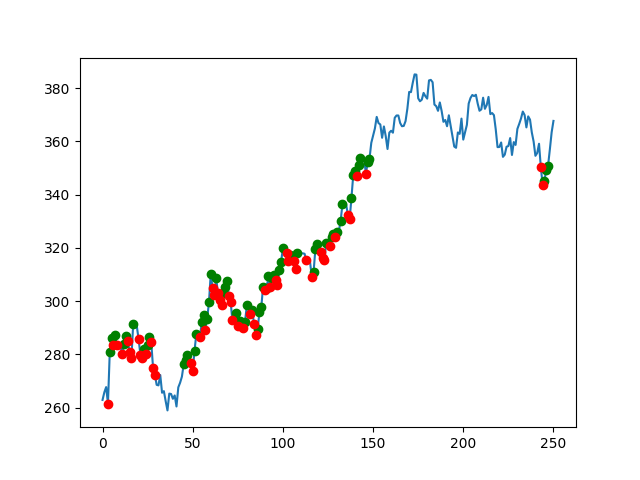

In [759]:
thresS = 1
thresB = -1
sell_max = 2000
buy_max= 2000

last_trans = start_price
invest = 0 #shares
start_cash = 10000
cash = start_cash

sell_log = []
buy_log = []

for k in range(len(prices)):
    P[k] = prices[k]

    if(P[k] > last_trans + thresS and invest > 0):
        sell_amt = min(sell_max, invest*P[k])
        invest -= sell_amt/P[k]
        cash += sell_amt
        sell_log.append(k)
        print(f"sel {round(sell_amt/P[k], 2)} shares at {round(P[k], 2)} for +${round(sell_amt, 2)}, cash={round(cash, 2)}, invest={round(invest, 2)}")
        last_trans = P[k]
    if(P[k] < last_trans + thresB and cash > 0):
        buy_amt = min(buy_max, cash)
        invest += buy_amt/P[k]
        cash -= buy_amt
        buy_log.append(k)
        print(f"buy {round(buy_amt/P[k], 2)} shares at {round(P[k], 2)} for -${round(buy_amt, 2)}, cash={round(cash,2)}, invest={round(invest,2)}")
        last_trans = P[k]

plt.figure()
plt.plot(P)
for k in sell_log:
    plt.plot(k, P[k], 'go')
for k in buy_log:
    plt.plot(k, P[k], 'ro')

earned = (cash + invest*P[-1]) - start_cash
earned_rate = 100 * earned/start_cash
print(f"cashback: {earned}")
print(f"earn rate %: {earned_rate}")
plt.show()